<a href="https://colab.research.google.com/github/patrickhamzaokello/ColabFavourites/blob/main/Mwonya_Audio_Processor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas numpy scikit-learn python-dotenv

In [7]:
import pandas as pd
import numpy as np
import json
import re
import os
from pathlib import Path

class AudioFeatureExtractor:
    """
    Extract features from audio model prediction files for machine learning.
    Processes markdown files containing model predictions and activation values.
    """

    def __init__(self):
        self.models = [
            'genre_dortmund', 'genre_rosamerica', 'genre_tzanetakis', 'genre_electronic',
            'mood_acoustic', 'mood_electronic', 'mood_aggressive', 'mood_relaxed',
            'mood_happy', 'mood_sad', 'mood_party', 'danceability', 'gender',
            'tonal_atonal', 'voice_instrumental'
        ]

    def parse_markdown_file(self, file_path):
        """
        Parse the markdown file containing model predictions.

        Args:
            file_path (str): Path to the markdown file

        Returns:
            dict: Dictionary containing parsed data with model predictions
        """
        with open(file_path, 'r') as f:
            content = f.read()

        # Extract filename from the first line
        first_line = content.split('\n')[0]
        filename = first_line.replace('# ', '')

        # Initialize data dictionary
        data = {
            'filename': filename,
            'features': {}
        }

        # Parse each model's predictions
        for model in self.models:
            pattern = rf"{model}\s*\|(.*?)\|(.*?)(?=\|\|<hr>|\Z)"
            match = re.search(pattern, content, re.DOTALL)

            if match:
                classes_text = match.group(1).strip()
                activations_text = match.group(2).strip()

                # Extract classes and activations
                classes = [c.strip() for c in classes_text.split('<br>')]
                activations = [float(a.strip().replace('**', '')) for a in activations_text.split('<br>')]

                # Store in the data dictionary
                data['features'][model] = {
                    'classes': classes,
                    'activations': activations
                }

        return data

    def extract_features(self, data):
        """
        Extract feature vector from parsed data.

        Args:
            data (dict): Parsed data from markdown file

        Returns:
            dict: Dictionary containing extracted features
        """
        features = {}

        # Extract top predictions and confidence scores for each model
        for model, model_data in data['features'].items():
            classes = model_data['classes']
            activations = model_data['activations']

            # Get top prediction (highest activation)
            if len(activations) > 0:
                top_index = np.argmax(activations)
                top_class = classes[top_index]
                top_activation = activations[top_index]

                features[f"{model}_top_class"] = top_class
                features[f"{model}_top_confidence"] = top_activation

                # For genre models, store top 3 genres
                if model.startswith('genre_'):
                    top_indices = np.argsort(activations)[-3:][::-1]

                    for i, idx in enumerate(top_indices):
                        if idx < len(classes) and idx < len(activations):
                            features[f"{model}_top{i+1}_class"] = classes[idx]
                            features[f"{model}_top{i+1}_confidence"] = activations[idx]

                # Store all activation values as features
                for i, (cls, act) in enumerate(zip(classes, activations)):
                    features[f"{model}_{cls.replace(' ', '_')}"] = act

        # Compute aggregate features

        # Emotion intensity (combination of mood models)
        if 'mood_happy_top_confidence' in features and 'mood_sad_top_confidence' in features:
            features['emotion_intensity'] = max(features['mood_happy_top_confidence'],
                                               features['mood_sad_top_confidence'])

        # Genre confidence (max confidence among genre models)
        genre_confidences = [features.get(f"{model}_top_confidence", 0)
                            for model in self.models if model.startswith('genre_')]
        features['genre_confidence'] = max(genre_confidences) if genre_confidences else 0

        return features

    def process_file(self, file_path):
        """
        Process a single markdown file and extract features.

        Args:
            file_path (str): Path to the markdown file

        Returns:
            tuple: (filename, features dictionary)
        """
        data = self.parse_markdown_file(file_path)
        features = self.extract_features(data)
        return data['filename'], features

    def process_directory(self, directory_path, output_file=None):
        """
        Process all markdown files in a directory and compile features.

        Args:
            directory_path (str): Path to directory containing markdown files
            output_file (str, optional): Path to save features as CSV

        Returns:
            pd.DataFrame: DataFrame containing extracted features for all files
        """
        results = []

        for file_path in Path(directory_path).glob('*.md'):
            try:
                filename, features = self.process_file(str(file_path))
                features['filename'] = filename
                results.append(features)
            except Exception as e:
                print(f"Error processing {file_path}: {e}")

        df = pd.DataFrame(results)

        if output_file:
            df.to_csv(output_file, index=False)

        return df

# Example usage
if __name__ == "__main__":
    # Process a single file
    extractor = AudioFeatureExtractor()
    filename, features = extractor.process_file("1850_replicate_file.md")

    print(f"Processed: {filename}")
    print("Features extracted:")
    for key, value in features.items():
        print(f"  {key}: {value}")

    # Example: Process a directory of files
    # df = extractor.process_directory("./audio_predictions/", "audio_features.csv")
    # print(f"Processed {len(df)} files and saved to audio_features.csv")

Processed: tmpley2pag2AFFECTION - A.L.A.K 1.mp3
Features extracted:
  genre_dortmund_top_class: raphiphop
  genre_dortmund_top_confidence: 0.49
  genre_dortmund_top1_class: raphiphop
  genre_dortmund_top1_confidence: 0.49
  genre_dortmund_top2_class: jazz
  genre_dortmund_top2_confidence: 0.06
  genre_dortmund_top3_class: pop
  genre_dortmund_top3_confidence: 0.06
  genre_dortmund_alternative: 0.03
  genre_dortmund_blues: 0.01
  genre_dortmund_electronic: 0.06
  genre_dortmund_folkcountry: 0.02
  genre_dortmund_funksoulrnb: 0.04
  genre_dortmund_jazz: 0.06
  genre_dortmund_pop: 0.06
  genre_dortmund_raphiphop: 0.49
  genre_dortmund_rock: 0.01
  genre_rosamerica_top_class: rhythm and blues
  genre_rosamerica_top_confidence: 0.26
  genre_rosamerica_top1_class: rhythm and blues
  genre_rosamerica_top1_confidence: 0.26
  genre_rosamerica_top2_class: speech
  genre_rosamerica_top2_confidence: 0.22
  genre_rosamerica_top3_class: pop
  genre_rosamerica_top3_confidence: 0.08
  genre_rosamerica

=== Processing Single File ===

Extracted 110 features from tmpley2pag2AFFECTION - A.L.A.K 1.mp3

Top genre predictions:
  genre_dortmund: raphiphop (0.49)
  genre_rosamerica: rhythm and blues (0.26)
  genre_tzanetakis: pop (0.31)
  genre_electronic: dnb (0.46)

Mood information:
  mood_acoustic: acoustic (0.74)
  mood_electronic: not electronic (0.64)
  mood_aggressive: not aggressive (1.00)
  mood_relaxed: relaxed (0.89)
  mood_happy: happy (0.56)
  mood_sad: sad (0.98)
  mood_party: not party (0.97)

Other characteristics:
  danceability: danceable (0.93)
  gender: male (0.67)
  tonal_atonal: tonal (0.94)
  voice_instrumental: voice (0.66)

=== Simulating ML Pipeline with Synthetic Data ===

Classification Report:
              precision    recall  f1-score   support

  electronic       1.00      1.00      1.00        10
      hiphop       1.00      1.00      1.00        15

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
w

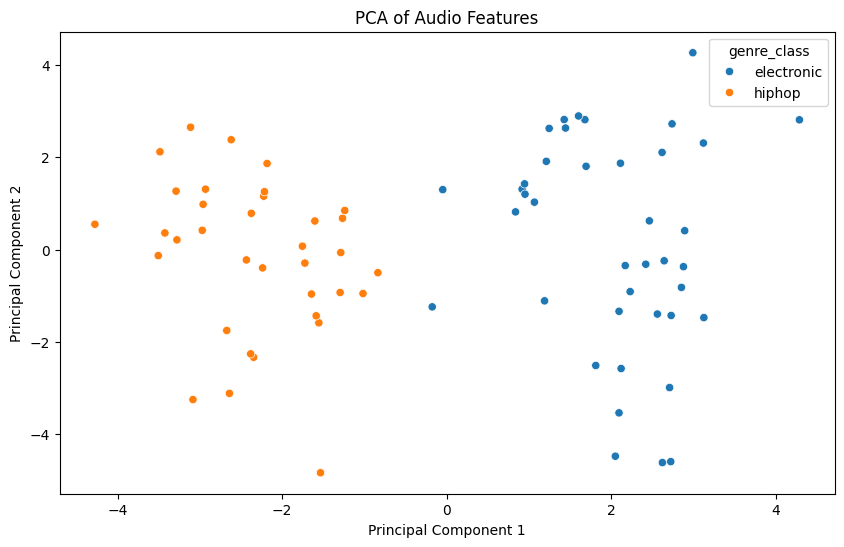

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import os

# Import our feature extractor
# from audio_feature_extraction import AudioFeatureExtractor

def demo_single_file():
    """
    Demonstrate extracting features from a single file
    """
    print("=== Processing Single File ===")
    extractor = AudioFeatureExtractor()
    filename, features = extractor.process_file("1850_replicate_file.md")

    print(f"\nExtracted {len(features)} features from {filename}")

    # Display top genre predictions across models
    print("\nTop genre predictions:")
    for model in extractor.models:
        if model.startswith('genre_'):
            top_class = features.get(f"{model}_top_class", "N/A")
            top_conf = features.get(f"{model}_top_confidence", 0)
            print(f"  {model}: {top_class} ({top_conf:.2f})")

    # Display mood information
    print("\nMood information:")
    mood_models = [m for m in extractor.models if m.startswith('mood_')]
    for model in mood_models:
        top_class = features.get(f"{model}_top_class", "N/A")
        top_conf = features.get(f"{model}_top_confidence", 0)
        print(f"  {model}: {top_class} ({top_conf:.2f})")

    # Other important audio characteristics
    print("\nOther characteristics:")
    other_models = ['danceability', 'gender', 'tonal_atonal', 'voice_instrumental']
    for model in other_models:
        top_class = features.get(f"{model}_top_class", "N/A")
        top_conf = features.get(f"{model}_top_confidence", 0)
        print(f"  {model}: {top_class} ({top_conf:.2f})")

    return features

def prepare_features_for_ml(features_list):
    """
    Convert features list to DataFrame suitable for ML
    """
    # Convert to DataFrame
    df = pd.DataFrame(features_list)

    # Handle categorical variables
    # Extract and encode categorical features
    categorical_cols = [col for col in df.columns if col.endswith('_class')]
    for col in categorical_cols:
        df[col] = df[col].astype('category').cat.codes

    # Get numerical features only
    numerical_features = df.select_dtypes(include=['float64', 'int64'])

    # Remove any columns with NaN values
    clean_features = numerical_features.dropna(axis=1)

    return clean_features

def simulate_ml_pipeline(num_files=100):
    """
    Simulate a machine learning pipeline with synthetic data
    """
    print("\n=== Simulating ML Pipeline with Synthetic Data ===")

    # Get features from the real file to understand structure
    extractor = AudioFeatureExtractor()
    _, real_features = extractor.process_file("1850_replicate_file.md")

    # Create synthetic dataset based on the real features
    features_list = []

    # Create two synthetic classes for demo purposes
    classes = ['hiphop', 'electronic']

    for i in range(num_files):
        # Copy the real features as a starting point
        synthetic_features = real_features.copy()

        # Assign a synthetic class
        assigned_class = classes[i % len(classes)]

        # Modify features based on the assigned class
        if assigned_class == 'hiphop':
            # Emphasize hiphop characteristics
            synthetic_features['genre_dortmund_raphiphop'] = 0.7 + np.random.random() * 0.3
            synthetic_features['mood_aggressive_aggressive'] = 0.4 + np.random.random() * 0.6
            synthetic_features['mood_relaxed_relaxed'] = np.random.random() * 0.4
        else:
            # Emphasize electronic characteristics
            synthetic_features['genre_electronic_house'] = 0.6 + np.random.random() * 0.4
            synthetic_features['mood_electronic_electronic'] = 0.7 + np.random.random() * 0.3
            synthetic_features['mood_relaxed_relaxed'] = 0.5 + np.random.random() * 0.5

        # Add noise to all features
        for key in synthetic_features:
            if isinstance(synthetic_features[key], (float, int)) and key != 'filename':
                synthetic_features[key] += np.random.normal(0, 0.1)
                # Ensure values are within valid range
                if key.endswith('confidence') or 'activation' in key:
                    synthetic_features[key] = max(0, min(1, synthetic_features[key]))

        # Add the class and filename
        synthetic_features['genre_class'] = assigned_class
        synthetic_features['filename'] = f"synthetic_file_{i}.mp3"

        features_list.append(synthetic_features)

    # Prepare features for ML
    df = pd.DataFrame(features_list)

    # Define target variable
    y = df['genre_class']

    # Prepare features
    X = prepare_features_for_ml(features_list)

    # Make sure to remove the target from features
    if 'genre_class' in X.columns:
        X = X.drop('genre_class', axis=1)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train a model
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train_scaled, y_train)

    # Evaluate
    y_pred = model.predict(X_test_scaled)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Feature importance
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': model.feature_importances_
    }).sort_values('Importance', ascending=False)

    print("\nTop 10 Most Important Features:")
    print(feature_importance.head(10))

    # Visualize with PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_train_scaled)

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_train)
    plt.title('PCA of Audio Features')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.savefig('audio_features_pca.png')
    print("\nPCA visualization saved to 'audio_features_pca.png'")

    return model, feature_importance

if __name__ == "__main__":
    # Process single file example
    features = demo_single_file()

    # Simulate ML pipeline with synthetic data
    model, importance = simulate_ml_pipeline(100)

    print("\n=== Applying to New Data ===")
    print("To classify a new audio file, you would:")
    print("1. Process the new file with AudioFeatureExtractor")
    print("2. Prepare the features using the same preprocessing steps")
    print("3. Use the trained model to predict the class")

    print("\nExample code for classifying a new file:")
    print("""
    # Process new file
    extractor = AudioFeatureExtractor()
    filename, features = extractor.process_file("new_audio_file.md")

    # Prepare features (same preprocessing as training data)
    features_df = pd.DataFrame([features])
    # ... apply same preprocessing steps ...

    # Predict
    prediction = model.predict(features_df_processed)
    print(f"Predicted genre: {prediction[0]}")
    """)

Processing files from /content/drive/MyDrive/replicate...
Found 1418 markdown files


100%|██████████| 1418/1418 [00:19<00:00, 73.69it/s] 


Dataset saved to audio_features.csv
Generating visualizations...
Visualizations saved to visualizations
Enhanced dataset with detected genres saved to audio_features_with_genres.csv

Dataset Statistics:
Total files processed: 1418

Files by detected genre:
  raphiphop: 773
  unknown: 393
  hip hop: 88
  pop: 68
  rhythm and blues: 47
  electronic: 13
  reggae: 11
  techno: 6
  dance: 6
  dnb: 5
  ambient: 5
  blues: 2
  folkcountry: 1


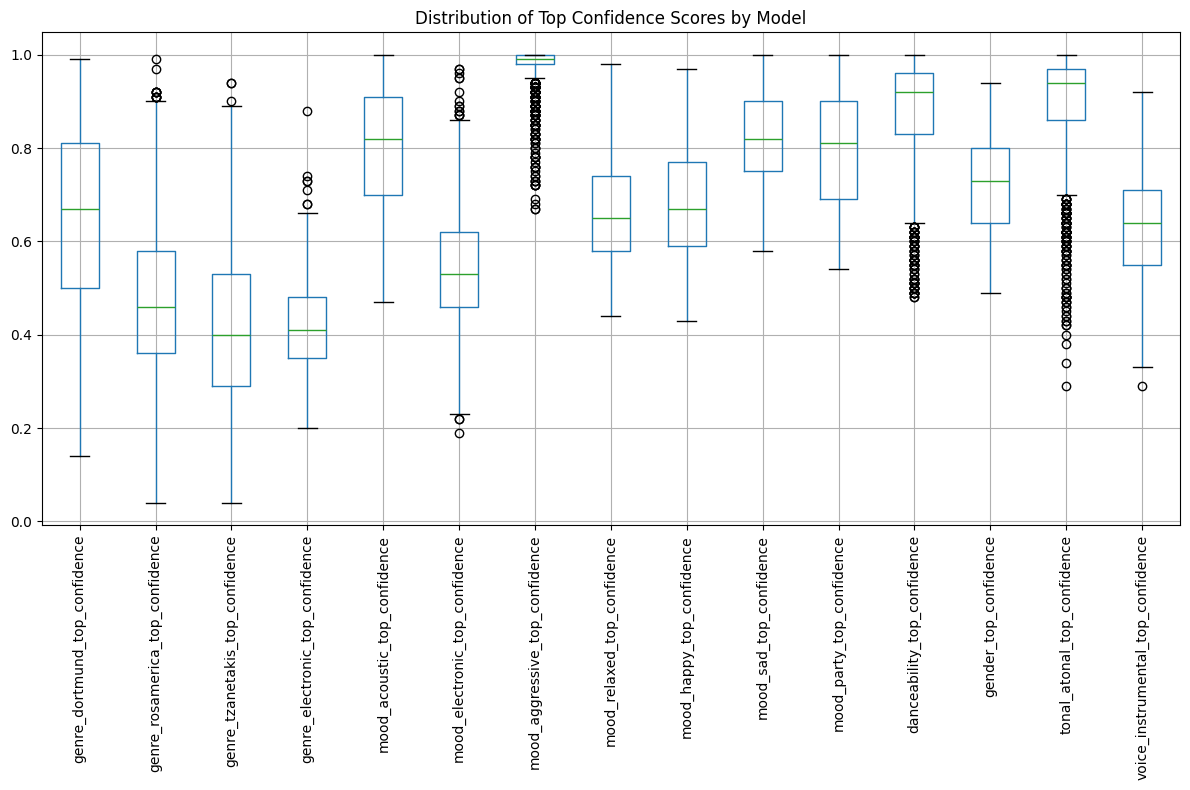

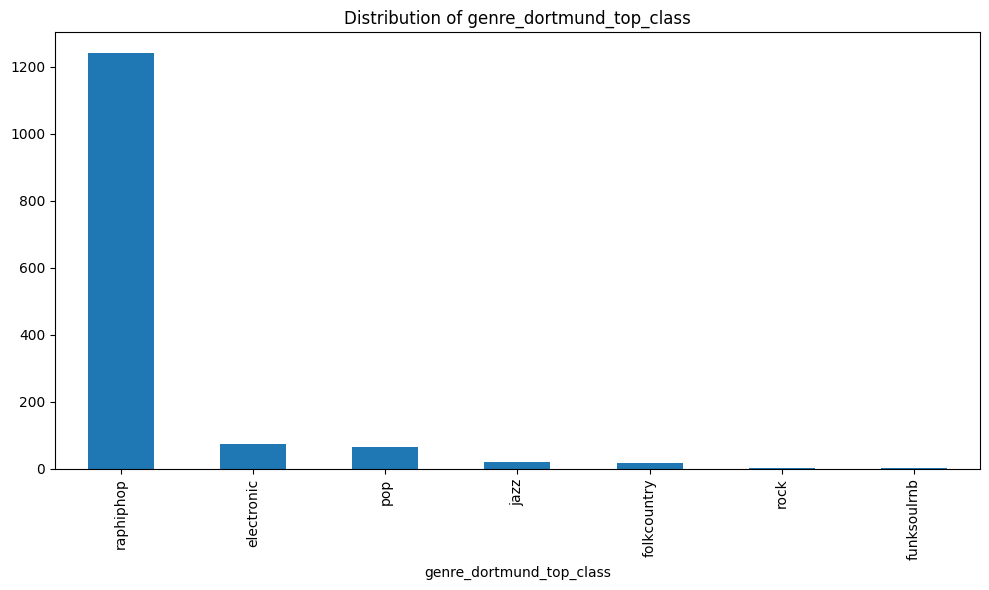

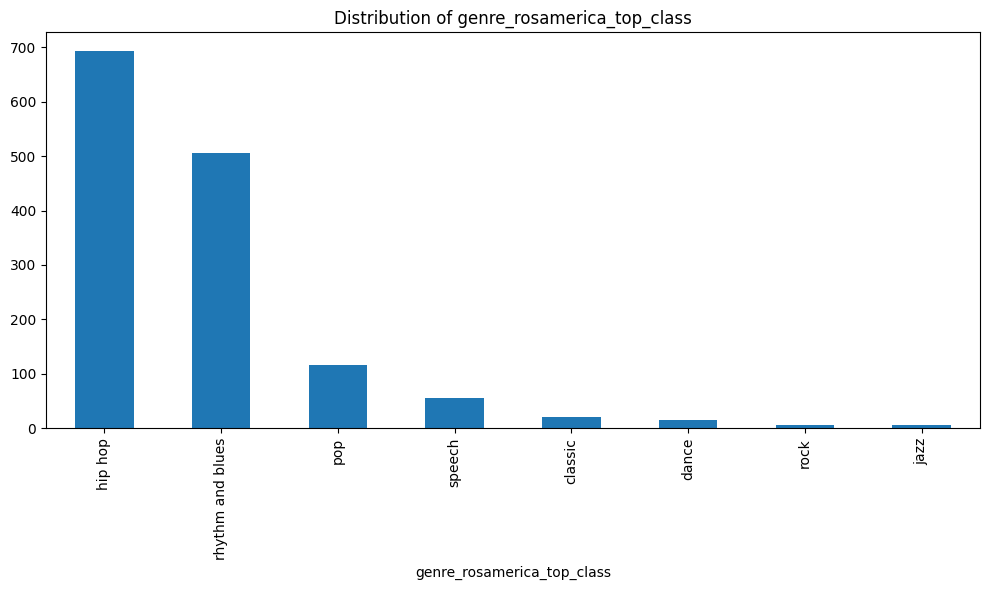

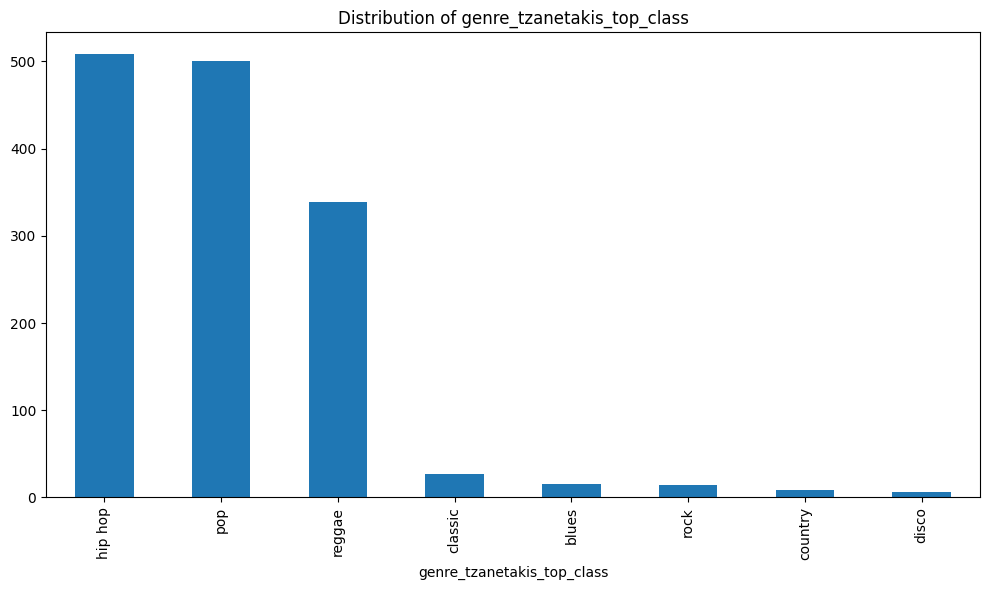

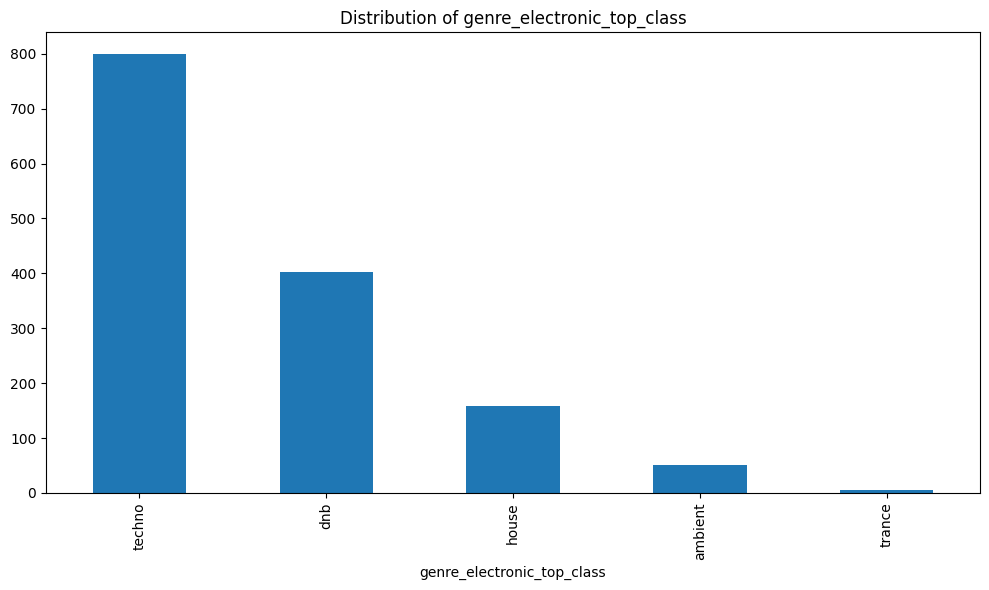

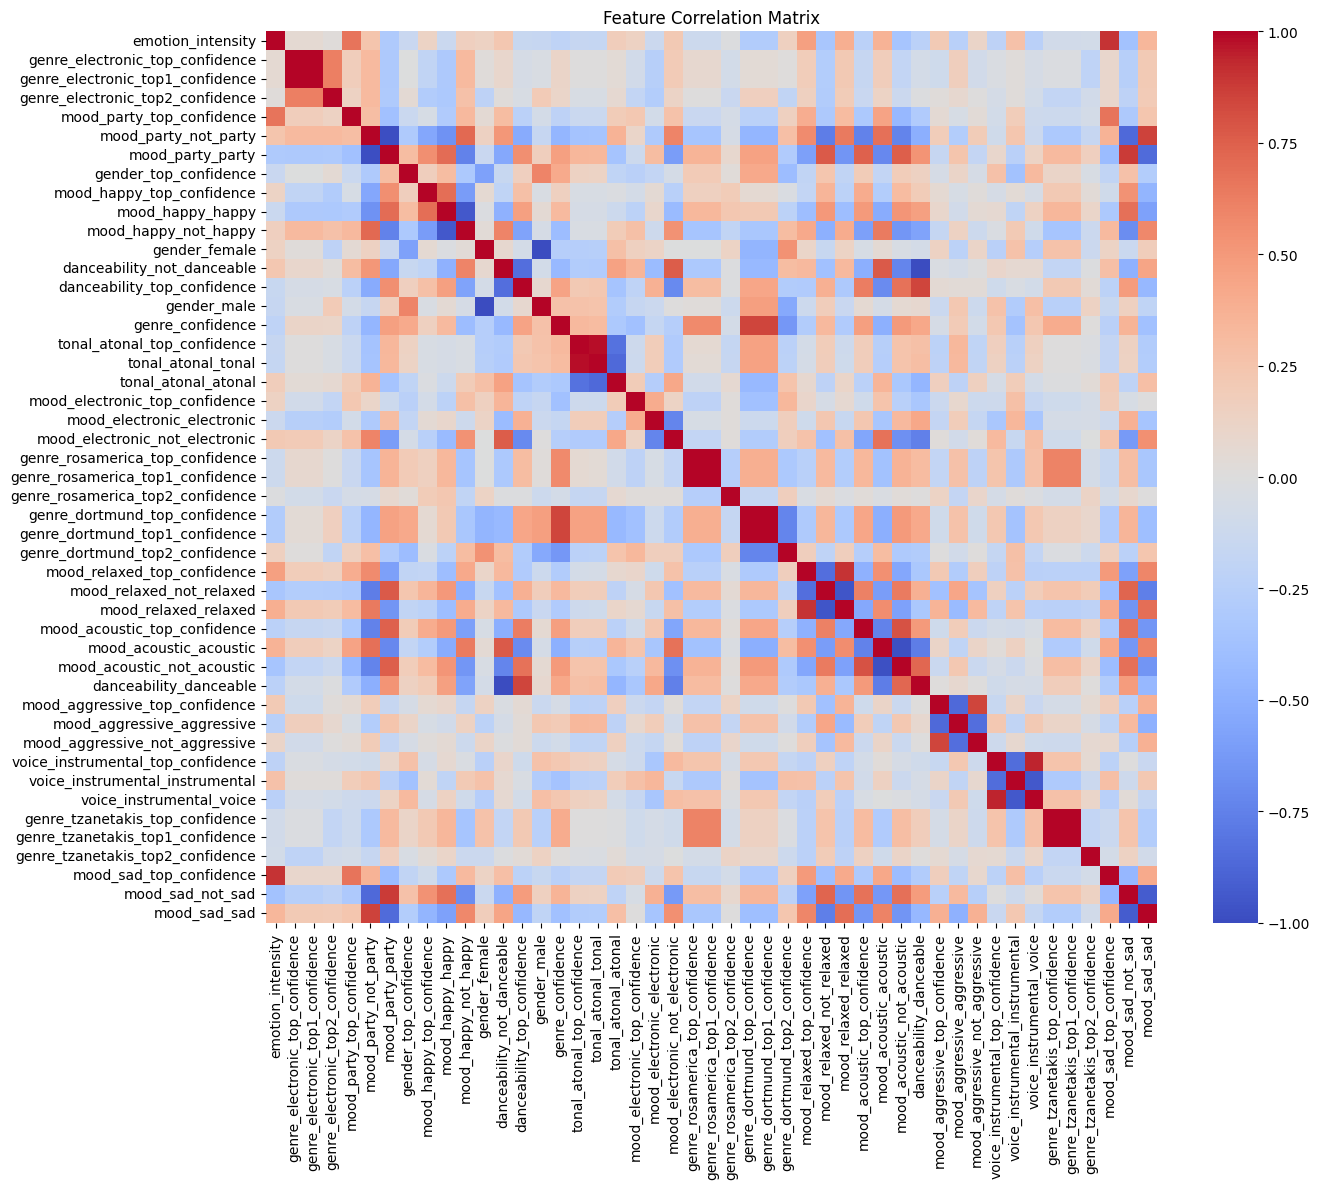

In [14]:
#!/usr/bin/env python3
"""
Build a machine learning dataset from audio prediction files.
This script takes a directory of markdown files containing audio model predictions
and builds a dataset suitable for machine learning.
"""

import os
import argparse
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Import our feature extractor
# from audio_feature_extraction import AudioFeatureExtractor

def build_dataset(input_dir, output_file, visualize=False):
    """
    Build a dataset from a directory of markdown files.

    Args:
        input_dir (str): Directory containing markdown files with model predictions
        output_file (str): Path to save the output CSV
        visualize (bool): Whether to generate visualizations

    Returns:
        pd.DataFrame: DataFrame containing the extracted features
    """
    print(f"Processing files from {input_dir}...")

    # Create feature extractor
    extractor = AudioFeatureExtractor()

    # Get all markdown files
    files = list(Path(input_dir).glob('*.md'))
    print(f"Found {len(files)} markdown files")

    # Process each file
    all_features = []
    for file_path in tqdm(files):
        try:
            filename, features = extractor.process_file(str(file_path))
            features['filename'] = filename
            all_features.append(features)
        except Exception as e:
            print(f"Error processing {file_path}: {e}")

    # Create DataFrame
    df = pd.DataFrame(all_features)

    # Save to CSV
    df.to_csv(output_file, index=False)
    print(f"Dataset saved to {output_file}")

    # Generate visualizations if requested
    if visualize:
        output_dir = os.path.dirname(output_file)
        create_visualizations(df, output_dir)

    return df

def create_visualizations(df, output_dir):
    """
    Create visualizations from the feature dataset.

    Args:
        df (pd.DataFrame): DataFrame containing features
        output_dir (str): Directory to save visualizations
    """
    print("Generating visualizations...")
    os.makedirs(os.path.join(output_dir, 'visualizations'), exist_ok=True)

    # Get all confidence/activation columns
    conf_cols = [col for col in df.columns if any(s in col for s in ['confidence', 'activation'])]

    # Plot distributions of top confidence scores
    top_conf_cols = [col for col in df.columns if 'top_confidence' in col]
    if top_conf_cols:
        plt.figure(figsize=(12, 8))
        df[top_conf_cols].boxplot()
        plt.title('Distribution of Top Confidence Scores by Model')
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'visualizations', 'top_confidence_distributions.png'))

    # Genre distribution
    genre_cols = [col for col in df.columns if col.startswith('genre_') and col.endswith('_top_class')]
    for col in genre_cols:
        if col in df.columns:
            plt.figure(figsize=(10, 6))
            df[col].value_counts().plot(kind='bar')
            plt.title(f'Distribution of {col}')
            plt.xticks(rotation=90)
            plt.tight_layout()
            plt.savefig(os.path.join(output_dir, 'visualizations', f'{col}_distribution.png'))

    # Correlation matrix of numerical features
    num_df = df.select_dtypes(include=[np.number])
    if not num_df.empty:
        plt.figure(figsize=(14, 12))

        # If there are too many features, select a subset
        if num_df.shape[1] > 30:
            # Select top activation columns from each model
            selected_cols = []
            for model in set([col.split('_')[0] + '_' + col.split('_')[1] for col in num_df.columns if '_' in col]):
                model_cols = [col for col in num_df.columns if col.startswith(model)]
                if model_cols:
                    selected_cols.extend(model_cols[:3])  # Take up to 3 columns per model

            if selected_cols:
                num_df = num_df[selected_cols]

        # Calculate and plot correlation matrix
        corr = num_df.corr()
        sns.heatmap(corr, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
        plt.title('Feature Correlation Matrix')
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'visualizations', 'correlation_matrix.png'))

    print(f"Visualizations saved to {os.path.join(output_dir, 'visualizations')}")

def detect_genres(df, threshold=0.6):
    """
    Detect primary genres for each file based on confidence scores.

    Args:
        df (pd.DataFrame): DataFrame with features
        threshold (float): Confidence threshold for genre detection

    Returns:
        pd.DataFrame: DataFrame with detected genre labels
    """
    # Create a copy to avoid modifying the original
    result_df = df.copy()

    # Get genre columns
    genre_cols = {}
    for model in ['genre_dortmund', 'genre_rosamerica', 'genre_tzanetakis', 'genre_electronic']:
        if f"{model}_top_class" in df.columns and f"{model}_top_confidence" in df.columns:
            genre_cols[model] = (f"{model}_top_class", f"{model}_top_confidence")

    # Add detected genre column
    result_df['detected_genre'] = 'unknown'

    # Detect primary genre for each file
    for idx, row in result_df.iterrows():
        genres = []
        for model, (class_col, conf_col) in genre_cols.items():
            if row[conf_col] >= threshold:
                genres.append(row[class_col])

        if genres:
            # Use the most common genre
            from collections import Counter
            most_common = Counter(genres).most_common(1)[0][0]
            result_df.at[idx, 'detected_genre'] = most_common

    return result_df

def main():
    # parser = argparse.ArgumentParser(description='Build ML dataset from audio prediction files')
    # parser.add_argument('input_dir', default= '/content/drive/MyDrive/replicate', help='Directory containing markdown files')
    # parser.add_argument('--output', '-o', default='audio_features.csv', help='Output CSV file')
    # parser.add_argument('--visualize', '-v', action='store_true', help='Generate visualizations')
    # args = parser.parse_args()

    # # Build dataset
    # df = build_dataset(args.input_dir, args.output, args.visualize)

    output = 'audio_features.csv'

    df = build_dataset('/content/drive/MyDrive/replicate', 'audio_features.csv', True)

    # Add genre detection
    df_with_genres = detect_genres(df)

    # Save enhanced dataset
    output_genres = output.replace('.csv', '_with_genres.csv')
    df_with_genres.to_csv(output_genres, index=False)
    print(f"Enhanced dataset with detected genres saved to {output_genres}")

    # Print statistics
    print("\nDataset Statistics:")
    print(f"Total files processed: {len(df)}")

    # Count files by detected genre
    genre_counts = df_with_genres['detected_genre'].value_counts()
    print("\nFiles by detected genre:")
    for genre, count in genre_counts.items():
        print(f"  {genre}: {count}")

if __name__ == "__main__":
    main()

In [17]:
import pandas as pd
import random
from pathlib import Path

# Load the dataset
df = pd.read_csv("audio_features.csv")

# Ensure 'filename' exists and clean paths
df['filename'] = df['filename'].str.replace('.mp3', '').str.strip()

# --- Playlist Generation Rules ---
def generate_playlists(df, max_songs=10):
    playlists = {}

    # 1. Genre-Based Playlists
    genre_cols = [col for col in df.columns if col.startswith('genre_') and '_top_class' in col]
    for col in genre_cols:
        genre_name = col.replace('_top_class', '')
        genres = df[col].unique()
        for genre in genres:
            key = f"Genre: {genre} ({genre_name})"
            songs = df[df[col] == genre]['filename'].tolist()
            if songs:
                playlists[key] = random.sample(songs, min(max_songs, len(songs)))

    # 2. Mood-Based Playlists (happy, sad, party, etc.)
    mood_pairs = [
        ('mood_happy_happy', 'Happy'),
        ('mood_sad_sad', 'Sad'),
        ('mood_party_party', 'Party'),
        ('mood_relaxed_relaxed', 'Relaxed')
    ]
    for col, mood_name in mood_pairs:
        # Get songs where mood activation > threshold (e.g., top 50%)
        threshold = df[col].quantile(0.75)  # Adjust threshold as needed
        songs = df[df[col] > threshold]['filename'].tolist()
        if songs:
            playlists[f"Mood: {mood_name}"] = random.sample(songs, min(max_songs, len(songs)))

    # 3. Danceability Playlists
    if 'danceability_top_confidence' in df.columns:
        dance_songs = df.sort_values('danceability_top_confidence', ascending=False)['filename'].head(max_songs).tolist()
        playlists["Dance: High Energy"] = dance_songs

    # 4. Hybrid Playlists (e.g., "Happy Hip-Hop")
    hybrid_rules = [
        ('genre_dortmund_top_class', 'hiphop', 'mood_happy', 'Happy Hip-Hop'),
        ('genre_electronic_top_class', 'house', 'mood_party', 'House Party'),
        ('genre_dortmund_top_class', 'rock', 'mood_aggressive', 'Rock Anthems')
    ]
    for genre_col, genre_val, mood_col, playlist_name in hybrid_rules:
        if genre_col in df.columns and mood_col in df.columns:
            songs = df[(df[genre_col] == genre_val) & (df[mood_col] > df[mood_col].median())]['filename'].tolist()
            if songs:
                playlists[playlist_name] = random.sample(songs, min(max_songs, len(songs)))

    # 5. Random Mix (Fallback)
    all_songs = df['filename'].tolist()
    playlists["Random Mix"] = random.sample(all_songs, min(max_songs, len(all_songs)))

    return playlists

# --- Generate and Export Playlists ---
def export_playlists(playlists, output_dir="playlists"):
    Path(output_dir).mkdir(exist_ok=True)
    for name, songs in playlists.items():
        safe_name = "".join(c if c.isalnum() else "_" for c in name)
        with open(f"{output_dir}/{safe_name}.m3u", "w") as f:
            f.write("#EXTM3U\n")
            f.write("\n".join([f"{song}.mp3" for song in songs]))
    print(f"Exported {len(playlists)} playlists to '{output_dir}/'")

# Run the pipeline
playlists = generate_playlists(df)
export_playlists(playlists)

Exported 34 playlists to 'playlists/'
